# 2. Entrenamiento de RNNs en una Serie de Tiempo

#### (a) Se carga el dataset y se escala.

In [103]:
import pandas

dataframe = pandas.read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataframe[:] = dataframe[:].astype('float32')
df_train, df_test = dataframe[0:96].values, dataframe[96:].values

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1)).fit(df_train)
stream_train_scaled = scaler.transform(df_train)
stream_test_scaled = scaler.transform(df_test)

#### (b) Definición del creador del dataset.

In [109]:
import numpy as np

def create_dataset(dataset, lag=1):
    dataX = []
    dataY = []
    for i in range((len(dataset)-1)-lag):
        dataX.append(dataset[i:i+lag])
        dataY.append(dataset[i+lag])
    return np.array(dataX), np.array(dataY)

#### (c) Creación del dataset para trabajar.

In [110]:
lag = 3
trainX, trainY = create_dataset(stream_train_scaled, lag)
testX, testY = create_dataset(stream_test_scaled, lag)

#### (d) Transformación del dataset a la estructura requerida por la LSTM: [samples, time_steps, features]

In [111]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

#### (e) Entrenamiento de LSTM, con lag = 3.

In [114]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

modelo2 = Sequential()
modelo2.add(LSTM(4, input_shape=(1, lag), activation='tanh', recurrent_activation='sigmoid'))
modelo2.add(Dense(1))

modelo2.compile(loss='mean_squared_error', optimizer='adam')
resultados2=modelo2.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1)

Epoch 1/100
92/92 [==============================] - 1s - loss: 0.1089     
Epoch 2/100
92/92 [==============================] - 0s - loss: 0.0465     
Epoch 3/100
92/92 [==============================] - 0s - loss: 0.0246     
Epoch 4/100
92/92 [==============================] - 0s - loss: 0.0199     
Epoch 5/100
92/92 [==============================] - 0s - loss: 0.0181     
Epoch 6/100
92/92 [==============================] - 0s - loss: 0.0166     
Epoch 7/100
92/92 [==============================] - 0s - loss: 0.0153     
Epoch 8/100
92/92 [==============================] - 0s - loss: 0.0143     
Epoch 9/100
92/92 [==============================] - 0s - loss: 0.0135     
Epoch 10/100
92/92 [==============================] - 0s - loss: 0.0126     
Epoch 11/100
92/92 [==============================] - 0s - loss: 0.0121     
Epoch 12/100
92/92 [==============================] - 0s - loss: 0.0116     
Epoch 13/100
92/92 [==============================] - 0s - loss: 0.0116     
Epoch 14

#### (f) Realización de predicciones en base a los conjuntos de entrenamiento y prueba, usando el modelo recién entrenado.

In [115]:
trainPredict = modelo2.predict(trainX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)

testPredict = modelo2.predict(testX)

testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

#### (g) Cálculo del RMSE (Root Mean Squared Error) sobre conjuntos de entrenamiento y prueba.

In [116]:
from sklearn.metrics import mean_squared_error
import math

trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:, 0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:, 0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 22.82 RMSE
Test Score: 60.61 RMSE


#### (h) Gráfica de predicciones sobre el conjunto de entrenamiento y prueba. Contraste con la serie original.

c:\program files\python35\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


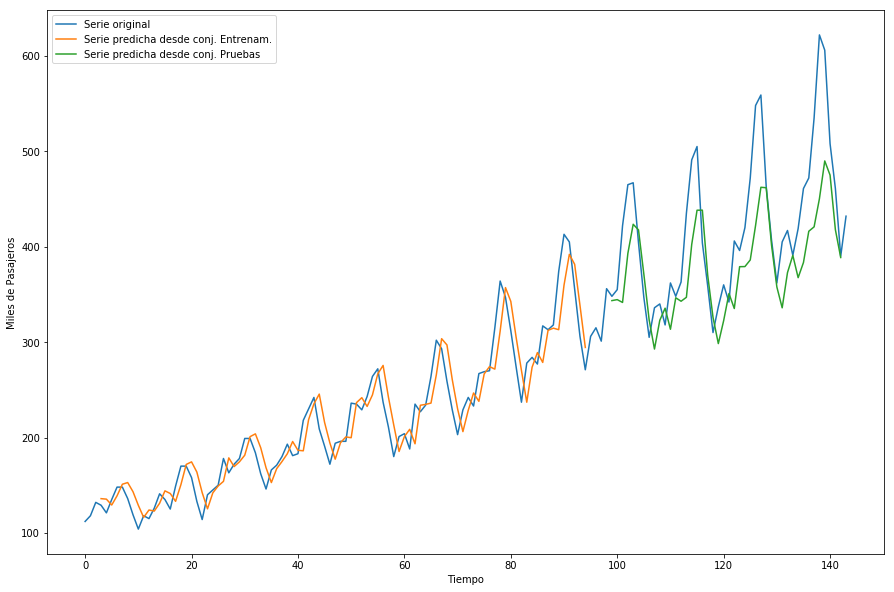

In [132]:
import matplotlib.pyplot as plt

trainPredictPlot = np.empty_like(dataframe.values)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lag:len(trainPredict)+lag, :] = trainPredict

testPredictPlot = np.empty_like(dataframe.values)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(2*lag)+1:len(dataframe.values)-1, :] = testPredict

plt.subplots(1,1,figsize=(15,10))
plt.subplot(1,1,1)
plt.plot(scaler.inverse_transform(np.append(stream_train_scaled, stream_test_scaled)), label='Serie original')
plt.plot(trainPredictPlot, label='Serie predicha desde conj. Entrenam.')
plt.plot(testPredictPlot, label='Serie predicha desde conj. Pruebas')
plt.ylabel('Miles de Pasajeros')
plt.xlabel('Tiempo')
plt.legend(loc='upper left')
plt.show()

Como es de esperarse, la predicción basada en la serie del conjunto de entrenamiento (línea naranja) se ajusta muy bien a la original (azul), pues en ésta se basó su entrenamiento. Esto cambia cuando se intenta predecir en base a la parte de la serie usada para prueba (verde), donde, en la serie original, se observa que los peaks de pasajeros aumentan de forma más pronunciada conforme avanza el tiempo. Se nota que la LSTM predice aproximadamente bien la cantidad de pasajeros en los valles, pero subestima notoriamente los peaks: justo antes del tiempo $t=140$, el flujo real de pasajeros sobrepasa por aproximadamente 150 mil lo predicho por la red.

Notar que la línea verde no está presente en $t \in [96, 98]$, pues esas tres etapas de tiempo se necesitaron para comenzar a construir la predicción, ya que se eligió $lag = 3$. Ocurre lo mismo con la predicción de entrenamiento (naranja) en $t \in [0, 2]$.

#### (h) Determinación de número de bloques LSTM usando 5-fold Cross Validation.

In [ ]:
nb = range(2,13, 2)
modelo2_2 = Sequential()
modelo2_2.add(LSTM(nb, input_shape(1, lag)m activation='tanh', recurrent_activation='sigmoid'))
modelo2_2.add(Dense(1))